# This Example shows how to classify EuroSAT satellite images using the deep learning model DeepSAT-V2.

### EuroSAT satellite dataset contains images from 10 different classes:

<ul>
<li>Annual Crop</li>
<li>Forest</li>
<li>Herbaceous Vegetation</li>
<li>Highway</li>
<li>Industrial</li>
<li>Pasture</li>
<li>Permanent Crop</li>
<li>Residential</li>
<li>River</li>
<li>SeaLake</li>
</ul>

### Import Modules

In [ ]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from geotorchai.models.raster import SatCNN
from geotorchai.preprocessing.torch_df import RasterClassificationDf
from geotorchai.preprocessing import SedonaRegistration, load_geotiff_image_as_binary_data
from geotorchai.preprocessing.raster import RasterProcessing as rp
from geotorchai.utility import TorchAdapter

# Import Apache Sedona
from sedona.spark import *

## Import PySpark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, udf, expr, array, concat


## Import distributed modules
from torch.utils.data import DistributedSampler, DataLoader
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from pyspark.ml.torch.distributor import TorchDistributor
from petastorm import TransformSpec

import warnings
# Ignore FutureWarning warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Define spark session and Register with GeoTorchAI

In [2]:
config = SedonaContext.builder().master(MASTER_URL).config('spark.jars.packages',
           'org.apache.sedona:sedona-spark-shaded-3.4_2.12:1.4.1,'
           'org.datasyslab:geotools-wrapper:1.4.0-28.2').getOrCreate()

sedona = SedonaContext.create(config)
sc = sedona.sparkContext

23/08/11 18:58:23 WARN Utils: Your hostname, Kanchans-Laptop.local resolves to a loopback address: 127.0.0.1; using 192.168.1.6 instead (on interface en0)
23/08/11 18:58:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/kanchan/.ivy2/cache
The jars for the packages stored in: /Users/kanchan/.ivy2/jars
org.apache.sedona#sedona-spark-shaded-3.4_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-1c6446b8-5c7b-4898-981d-fb041cb3eb85;1.0
	confs: [default]


:: loading settings :: url = jar:file:/Users/kanchan/.pyenv/versions/3.11.0/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.apache.sedona#sedona-spark-shaded-3.4_2.12;1.4.1 in central
	found org.datasyslab#geotools-wrapper;1.4.0-28.2 in central
:: resolution report :: resolve 88ms :: artifacts dl 4ms
	:: modules in use:
	org.apache.sedona#sedona-spark-shaded-3.4_2.12;1.4.1 from central in [default]
	org.datasyslab#geotools-wrapper;1.4.0-28.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-1c6446b8-5c7b-4898-981d-fb041cb3eb85
	confs: [default]
	0 artifacts copied, 2 already retrieved (0kB/3ms)
23/08/11 18:58:24 WARN NativeCodeLoader: Unable to load

### Register SparkSession with GeoTorchAI

In [3]:
SedonaRegistration.set_sedona_context(sedona)

## Load Raster Data to Sedona

In [4]:
raster_df = load_geotiff_image_as_binary_data("data/eurosat_total/*.tif")
raster_df.show(5)

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|
+--------------------+--------------------+------+--------------------+
only showing top 5 rows



In [5]:
raster_df = rp.get_array_from_binary_raster(raster_df, 13, "content", col_new_array_data="array_data")
raster_df.show(5)

+--------------------+--------------------+------+--------------------+--------------------+
|                path|    modificationTime|length|             content|          array_data|
+--------------------+--------------------+------+--------------------+--------------------+
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1420.0, 1420.0, ...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1242.0, 1242.0, ...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1545.0, 1545.0, ...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1506.0, 1506.0, ...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1263.0, 1263.0, ...|
+--------------------+--------------------+------+--------------------+--------------------+
only showing top 5 rows



In [6]:
raster_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- array_data: array (nullable = true)
 |    |-- element: double (containsNull = true)



In [7]:
def get_name(file_path):
    return file_path.split("/")[-1].split("_")[0]

get_name_udf = udf(lambda x: get_name(x), StringType())

In [8]:
raster_df = raster_df.withColumn("category", get_name_udf(raster_df["path"]))
raster_df.show(5)

+--------------------+--------------------+------+--------------------+--------------------+----------+
|                path|    modificationTime|length|             content|          array_data|  category|
+--------------------+--------------------+------+--------------------+--------------------+----------+
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1420.0, 1420.0, ...|AnnualCrop|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1242.0, 1242.0, ...|AnnualCrop|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1545.0, 1545.0, ...|AnnualCrop|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1506.0, 1506.0, ...|AnnualCrop|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1263.0, 1263.0, ...|AnnualCrop|
+--------------------+--------------------+------+--------------------+--------------------+----------+
only showing top 5 rows



## Visualize the Bands of an Image

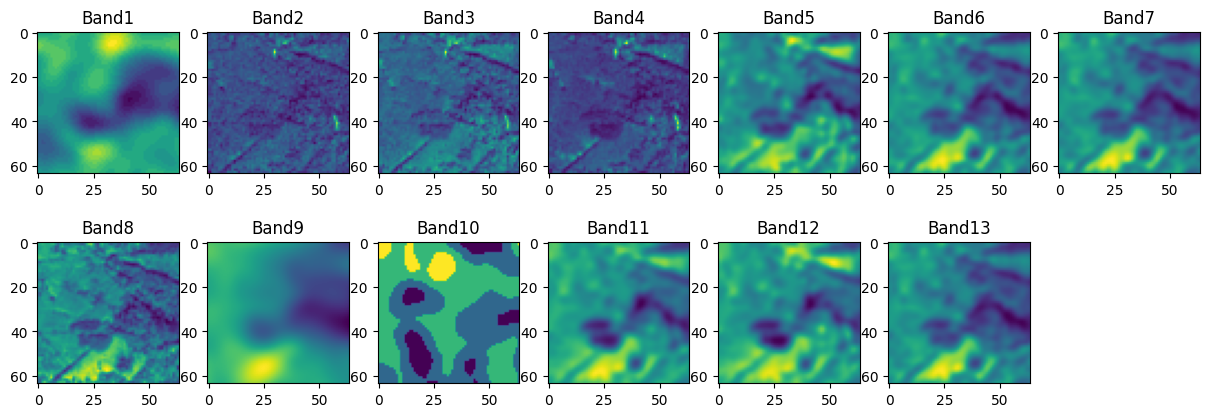

In [ ]:
img_index = 5
rp.visualize_all_bands(raster_df, "array_data", img_index, no_bands=13, height=64, width=64, axis_rows=2, axis_cols=7)

In [10]:
objRasterClassify = RasterClassificationDf(raster_df, "array_data", "category")
formatted_df = objRasterClassify.get_formatted_df()
transform_spec = objRasterClassify.get_transform_spec(13, 64, 64)

In [11]:
formatted_df.printSchema()

root
 |-- image_data: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- label: long (nullable = true)



In [12]:
from petastorm.spark import SparkDatasetConverter, make_spark_converter
sedona.conf.set(SparkDatasetConverter.PARENT_CACHE_DIR_URL_CONF, "file:///tmp/petastorm")

In [13]:
converter_train = make_spark_converter(formatted_df)
print(len(converter_train))

Converting floating-point columns to float32
The median size 855098 B (< 50 MB) of the parquet files is too small. Total size: 4284479 B. Increase the median file size by calling df.repartition(n) or df.coalesce(n), which might help improve the performance. Parquet files: file:///tmp/petastorm/20230811185837-appid-local-1691805505070-7b1acd8e-e947-46bd-9423-872ac5e9d900/part-00003-6464c92c-762f-4203-bce4-79c0d5e56a72-c000.parquet, ...


50


In [14]:
learning_rate = 0.0002
batch_size = 8
epoch_nums = 10

### Train Model
Accuracy will be very low since training is performed on a small dataset for only 2 epochs

In [15]:
def train_one_epoch(model, train_dataloader_iter, steps_per_epoch, optimizer, loss_fn, device):
    model.train()
    for step in range(steps_per_epoch):
        batch_data = next(train_dataloader_iter)
        inputs = batch_data['image_data']
        labels = batch_data['label']
        inputs = inputs.to(device)
        labels = labels.to(device)
            
        with torch.set_grad_enabled(True):
            optimizer.zero_grad()
                
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
                
            # Backward and optimize
            loss.backward()
            optimizer.step()
    return loss.item()

In [16]:
def train_model(model, device):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn.to(device)
    with converter_train.make_torch_dataloader(transform_spec=transform_spec, batch_size=batch_size) as train_dataloader:
        steps_per_epoch = len(converter_train) // batch_size
        train_dataloader_iter = iter(train_dataloader)
        for e in range(epoch_nums):
            epoch_loss = train_one_epoch(model, train_dataloader_iter, steps_per_epoch, optimizer, loss_fn)
            print('Epoch [{}/{}], Training Loss: {:.4f}'.format(e + 1, epoch_nums, epoch_loss))

In [17]:
def train_distributed(use_gpu):
    backend = "nccl" if use_gpu else "gloo"
    dist.init_process_group(backend)
    device = int(os.environ["LOCAL_RANK"]) if use_gpu  else "cpu"
    model = SatCNN(13, 64, 64, 10).to(device)
    model = DDP(model)
    
    output = train_model(model, device)
    #dist.cleanup()

## Start Distributed Training

In [ ]:
distributor = TorchDistributor(num_processes=4, local_mode=True, use_gpu=False)
distributor.run(train_distributed, False)